<a href="https://colab.research.google.com/github/alexrafkin/houseprice_regression/blob/main/RegressionChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn import linear_model
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

# Other Questions

In [ ]:
houseprices.shape

(1460, 81)

In [ ]:
houseprices.select_dtypes(exclude=object).shape

(1460, 38)

In [ ]:
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

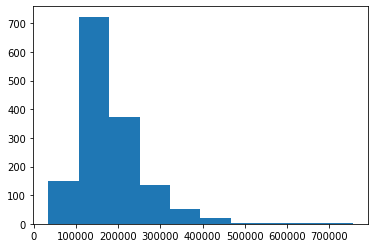

In [ ]:
plt.hist(houseprices.saleprice)
plt.show()

# Price Prediction

## Continuous Variables

In [ ]:
houseprices['totalsf'] = houseprices.totalbsmtsf + houseprices.firstflrsf + houseprices.secondflrsf + houseprices.garagearea + houseprices.wooddecksf + houseprices.openporchsf + houseprices.enclosedporch + houseprices.threessnporch + houseprices.screenporch

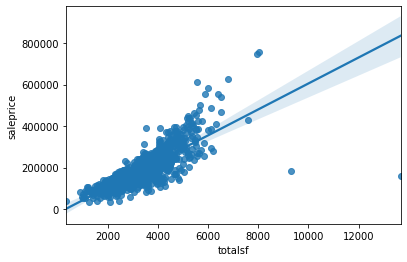

In [ ]:
sns.regplot(data=houseprices, y='saleprice', x='totalsf')

In [ ]:
houseprices.sort_values('totalsf').tail(2)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,totalsf
523,524,60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,...,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,None,None,None,0,10,2007,New,Partial,184750,9312
1298,1299,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,...,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,None,None,0,1,2008,New,Partial,160000,13676


In [ ]:
houseprices = houseprices.drop([523, 1298])

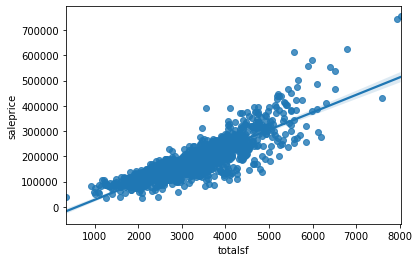

In [ ]:
sns.regplot(data=houseprices, y='saleprice', x='totalsf')

In [ ]:
houseprices.saleprice.corr(houseprices.totalsf)

0.8551160855620259

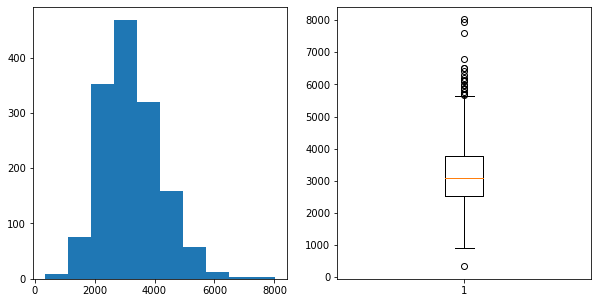

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(houseprices['totalsf'])
plt.subplot(1,2,2)
plt.boxplot(houseprices['totalsf'])
plt.show()

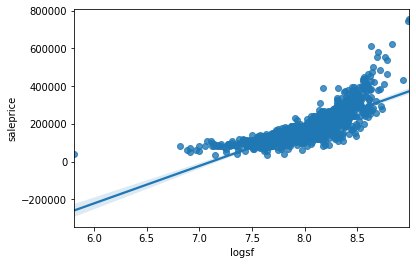

In [ ]:
houseprices['logsf'] = np.log(houseprices.totalsf)
sns.regplot(data=houseprices, y='saleprice', x='logsf')

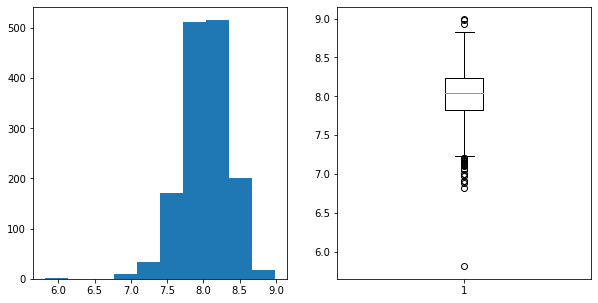

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(houseprices['logsf'])
plt.subplot(1,2,2)
plt.boxplot(houseprices['logsf'])
plt.show()

Definitely going to use totalsf as a feature - log kind of misrepresents the relationship and still has a fair amount of outliers, even though it looks a bit more normal.

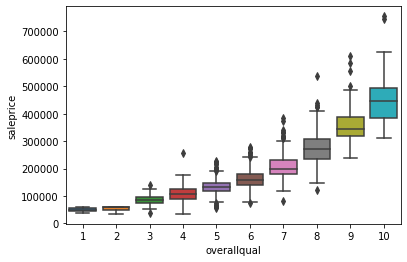

In [ ]:
sns.boxplot(y = houseprices.saleprice, x = houseprices.overallqual)

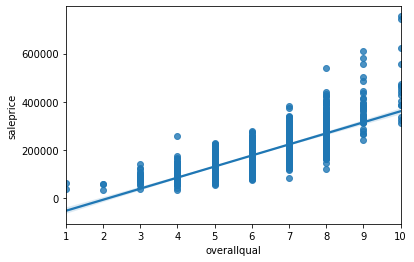

In [ ]:
sns.regplot(y=houseprices.saleprice, x = houseprices.overallqual)

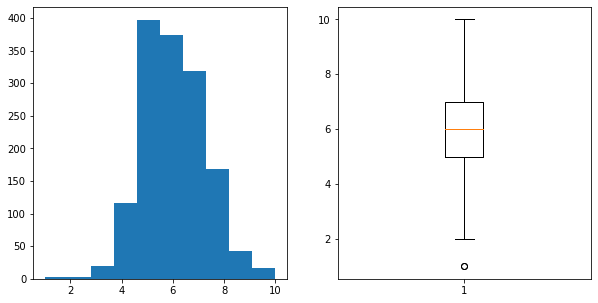

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(houseprices['overallqual'])
plt.subplot(1,2,2)
plt.boxplot(houseprices['overallqual'])
plt.show()

In [ ]:
houseprices.saleprice.corr(houseprices.overallqual)

0.7957742674249433

This will also be a good feature to use.

In [ ]:
houseprices['qualsf'] = houseprices.totalsf*houseprices.overallqual

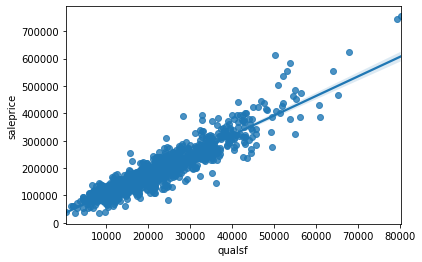

In [ ]:
sns.regplot(y=houseprices.saleprice, x = houseprices.qualsf)

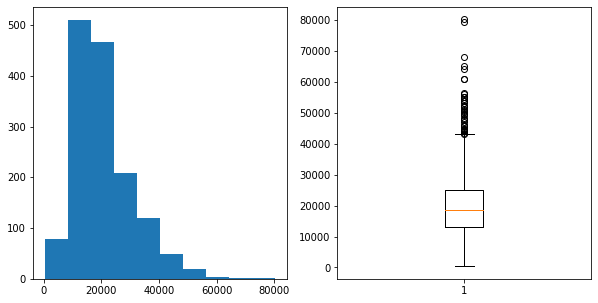

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(houseprices['qualsf'])
plt.subplot(1,2,2)
plt.boxplot(houseprices['qualsf'])
plt.show()

In [ ]:
houseprices.saleprice.corr(houseprices.qualsf)

0.92535525180537

This could be an interesting interaction feature.

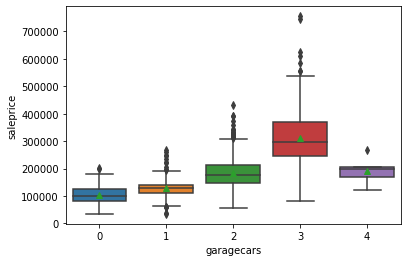

In [ ]:
sns.boxplot(y = houseprices.saleprice, x = houseprices.garagecars, showmeans=True)

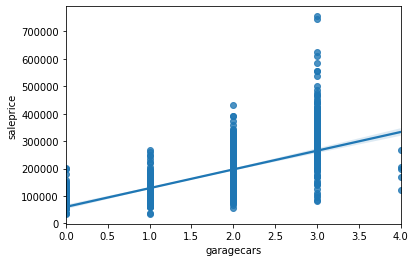

In [ ]:
sns.regplot(y=houseprices.saleprice, x = houseprices.garagecars)

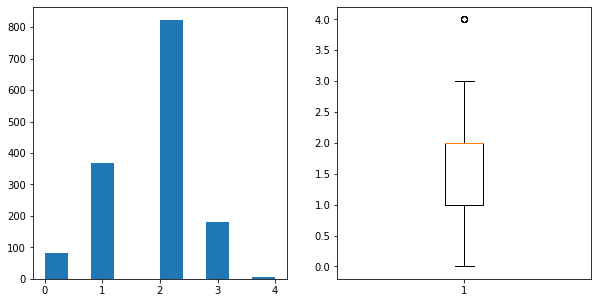

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(houseprices['garagecars'])
plt.subplot(1,2,2)
plt.boxplot(houseprices['garagecars'])
plt.show()

In [ ]:
houseprices.saleprice.corr(houseprices.garagecars)

0.6410470076412783

This could be another interesting feature.

## Categorical Variables

Now for some of the categorical variables:
I want to assess mszoning, and exterqual

In [ ]:
houseprices = pd.concat([houseprices,pd.get_dummies(houseprices.mszoning, prefix="mszoning")], axis=1)
houseprices = pd.concat([houseprices,pd.get_dummies(houseprices.exterqual, prefix="exterqual")], axis=1)
dummy_names = list(pd.get_dummies(houseprices.mszoning, prefix="mszoning").columns)
dummy_names = dummy_names + list(pd.get_dummies(houseprices.exterqual, prefix="exterqual").columns)
dummy_names

['mszoning_C (all)',
 'mszoning_FV',
 'mszoning_RH',
 'mszoning_RL',
 'mszoning_RM',
 'exterqual_Ex',
 'exterqual_Fa',
 'exterqual_Gd',
 'exterqual_TA']

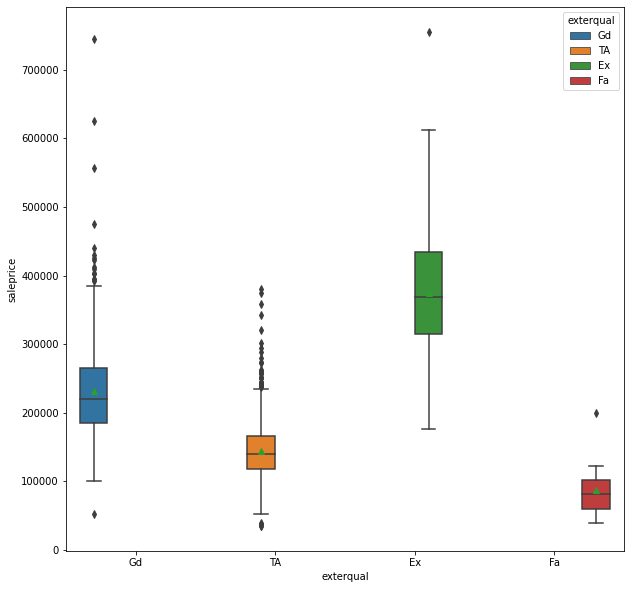

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=houseprices, x='exterqual', y='saleprice', hue='exterqual', showmeans=True)

There's a pretty large difference between the exterqual levels, lets drop the lowest.

In [ ]:
dummy_names.remove('exterqual_Fa')

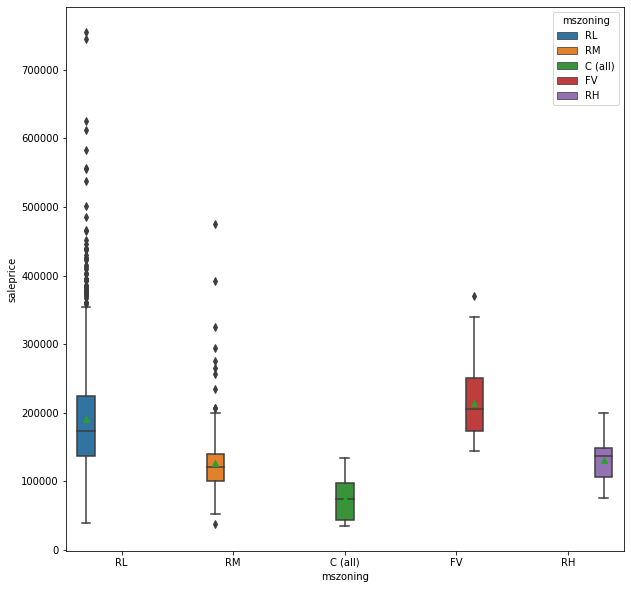

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=houseprices, x='mszoning', y='saleprice', hue='mszoning', showmeans=True)

Again, large difference between the levels, lets drop the lowest.

In [ ]:
dummy_names.remove('mszoning_C (all)')

## Model Setup

In [ ]:
# Y is the target variable
Y = houseprices['saleprice']
# X is the feature set
X = houseprices[['overallqual', 'garagecars', 'totalsf', 'qualsf'] + dummy_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1166
The number of observations in test set is 292


In [ ]:
X.corr()

,overallqual,garagecars,totalsf,qualsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,exterqual_Ex,exterqual_Gd,exterqual_TA
overallqual,1.000000,0.600741,0.702085,0.878068,0.173646,-0.064612,0.125678,-0.194985,0.373361,0.553695,-0.645552
garagecars,0.600741,1.000000,0.670689,0.673242,0.103245,-0.090424,0.174671,-0.221512,0.240683,0.426464,-0.481109
totalsf,0.702085,0.670689,1.000000,0.935262,0.022527,-0.045651,0.235506,-0.255822,0.333780,0.404323,-0.497410
qualsf,0.878068,0.673242,0.935262,1.000000,0.076439,-0.057953,0.199384,-0.236694,0.434427,0.482157,-0.610648
mszoning_FV,0.173646,0.103245,0.022527,0.076439,1.000000,-0.022754,-0.416545,-0.090573,0.014078,0.241166,-0.235633
mszoning_RH,-0.064612,-0.090424,-0.045651,-0.057953,-0.022754,1.000000,-0.203123,-0.044167,-0.019850,-0.060762,0.041502
mszoning_RL,0.125678,0.174671,0.235506,0.199384,-0.416545,-0.203123,1.000000,-0.808534,0.051614,0.065524,-0.058778
mszoning_RM,-0.194985,-0.221512,-0.255822,-0.236694,-0.090573,-0.044167,-0.808534,1.000000,-0.057876,-0.183275,0.188494
exterqual_Ex,0.373361,0.240683,0.333780,0.434427,0.014078,-0.019850,0.051614,-0.057876,1.000000,-0.133662,-0.241423
exterqual_Gd,0.553695,0.426464,0.404323,0.482157,0.241166,-0.060762,0.065524,-0.183275,-0.133662,1.000000,-0.908696


In [ ]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     944.8
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:53:30   Log-Likelihood:                -16987.
No. Observations:                1458   AIC:                         3.400e+04
Df Residuals:                    1446   BIC:                         3.406e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.832e+04    1.3e+04      6.005      0.000    5.27e+04    1.04e+05
overallqual  -1.704e+04   1732.884     -9.833      0.000   -2.04e+04   -1.36e+04
garagecars    4974.5497   1388.708      3.582      0.000    2250.452    7698.647
totalsf        -26.5146      3.309     -8.012      0.000     -33.006     -20.023
qualsf          10.6339      0.472     22.546      0.000       9.709      11.559
mszoning_FV   5.103e+04   9960.114      5.124      0.000    3.15e+04    7.06e+04
mszoning_RH   3.584e+04   1.14e+04      3.148      0.002    1.35e+04    5.82e+04
mszoning_RL   4.466e+04   9223.944      4.842      0.000    2.66e+04    6.28e+04
mszoning_RM   2.703e+04   9332.221      2.897      0.004    8725.445    4.53e+04
exterqual_Ex  5.008e+04   9553.583      5.242      0.000    3.13e+04    6.88e+04
exterqual_Gd  2.753e+04   8374.431      3.287      0.001    1.11e+04     4.4e+04
exterqual_TA  1.905e+04   8016.131      2.377      0.018    3329.155    3.48e+04
==============================================================================
Omnibus:                      215.757   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1933.537
Skew:                           0.382   Prob(JB):                         0.00
Kurtosis:                       8.590   Cond. No.                     6.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All features are statistically significant!

##Model Training

### Linear Regression

In [ ]:
# Fit an OLS model using scikit-learn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# You are making predictions here
y_preds_train = lrm.predict(X_train)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the prediction is: {}".format(mse(y_train, y_preds_train)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_train, y_preds_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))

R-squared of the model in the training set is: 0.8780439366955761
Mean absolute error of the prediction is: 19267.30511806744
Mean squared error of the prediction is: 801889245.4267997
Root mean squared error of the prediction is: 28317.649009527602
Mean absolute percentage error of the prediction is: 11.381238363277559


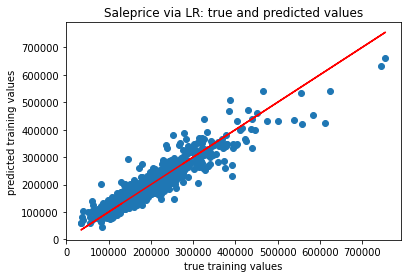

In [ ]:
plt.scatter(y_train, y_preds_train)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true training values")
plt.ylabel("predicted training values")
plt.title("Saleprice via LR: true and predicted values")
plt.show()

### Lasso

In [ ]:
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# You are making predictions here
y_preds_train = lasso_cv.predict(X_train)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the prediction is: {}".format(mse(y_train, y_preds_train)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_train, y_preds_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))

R-squared of the model in the training set is: 0.8780439366955761
Mean absolute error of the prediction is: 19268.491173350987
Mean squared error of the prediction is: 801892413.8991578
Root mean squared error of the prediction is: 28317.704954659686
Mean absolute percentage error of the prediction is: 11.383471590559248


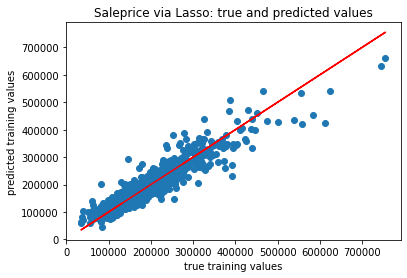

In [ ]:
plt.scatter(y_train, y_preds_train)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true training values")
plt.ylabel("predicted training values")
plt.title("Saleprice via Lasso: true and predicted values")
plt.show()

### Ridge

In [ ]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# You are making predictions here
y_preds_train = ridge_cv.predict(X_train)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the prediction is: {}".format(mse(y_train, y_preds_train)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_train, y_preds_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))

R-squared of the model in the training set is: 0.8780439366955761
Mean absolute error of the prediction is: 19297.44521440938
Mean squared error of the prediction is: 803325433.1157663
Root mean squared error of the prediction is: 28342.996191577316
Mean absolute percentage error of the prediction is: 11.439565291409458


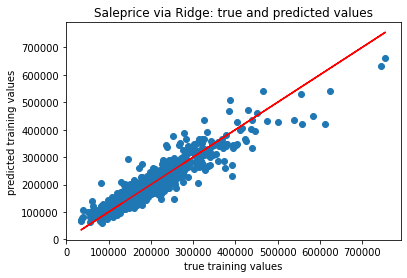

In [ ]:
plt.scatter(y_train, y_preds_train)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true training values")
plt.ylabel("predicted training values")
plt.title("Saleprice via Ridge: true and predicted values")
plt.show()

###ElasticNet

In [ ]:
EN_cv = ElasticNetCV(alphas=alphas, cv=5)
EN_cv.fit(X_train, y_train)

# You are making predictions here
y_preds_train = EN_cv.predict(X_train)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the prediction is: {}".format(mse(y_train, y_preds_train)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_train, y_preds_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))

R-squared of the model in the training set is: 0.8780439366955761
Mean absolute error of the prediction is: 19269.085140286887
Mean squared error of the prediction is: 801898705.9855919
Root mean squared error of the prediction is: 28317.816052541762
Mean absolute percentage error of the prediction is: 11.385440687055246


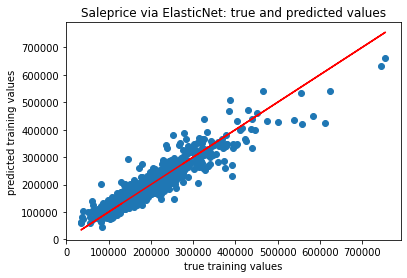

In [ ]:
plt.scatter(y_train, y_preds_train)
plt.plot(y_train, y_train, color="red")
plt.xlabel("true training values")
plt.ylabel("predicted training values")
plt.title("Saleprice via ElasticNet: true and predicted values")
plt.show()

It seems like unregularized linear regression has the most accurate fit for the training data.

##Testing

In [ ]:
y_preds_train = lrm.predict(X_test)

In [ ]:
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

-----Test set statistics-----
R-squared of the model in the test set is: 0.8754486450538309
Mean absolute error of the prediction is: 19526.035261055014
Mean squared error of the prediction is: 657454424.2443082
Root mean squared error of the prediction is: 25640.874092828977
Mean absolute percentage error of the prediction is: 12.3249031501897


We have a pretty good R^2 value, and low error values.

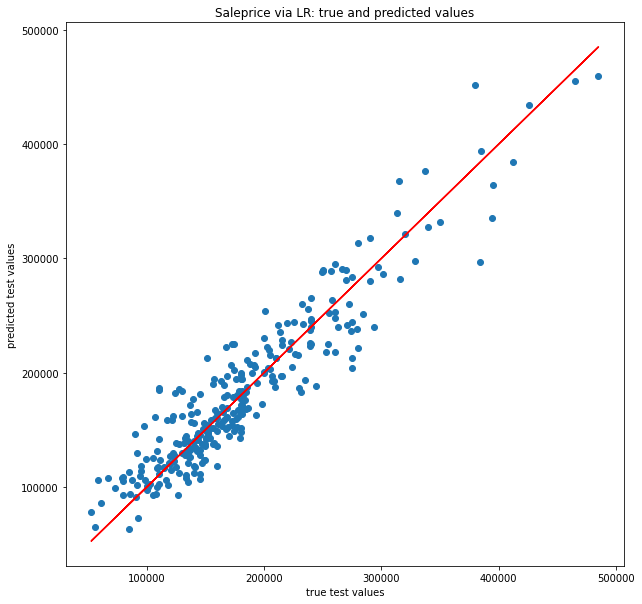

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true test values")
plt.ylabel("predicted test values")
plt.title("Saleprice via LR: true and predicted values")
plt.show()

I think that possibly adding the yearly +/- for the housing market/stock market for the year/year before the house was sold could speak to fluctuations in house value. Unemployment statistics could also drive prices in the housing market. 